In [23]:
# Install PySpark
!pip install -q pyspark



In [24]:
# Create Spark Session
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("BankingCustomerChurn") \
    .getOrCreate()

spark


In [25]:
from google.colab import files
uploaded = files.upload()  # click "Choose Files" and upload your CSV, e.g., Churn_Modelling.csv

# After upload, list files to confirm
import os
print("Files in /content/:")
print(os.listdir("/content"))


Saving Churn_Modelling.csv to Churn_Modelling (3).csv
Files in /content/:
['.config', 'Churn_Modelling (2).csv', 'gbt_churn_model', 'Churn_Modelling (3).csv', 'Churn_Modelling.csv', 'churn_predictions_parquet', 'Churn_Modelling (1).csv', 'sample_data']


In [26]:
# Change filename if different
csv_path = "/content/Churn_Modelling.csv"

df = spark.read.option("header", "true") \
               .option("inferSchema", "true") \
               .csv(csv_path)

# Basic checks
print("Number of rows:", df.count())
print("Columns:", df.columns)
df.printSchema()
df.show(5)


Number of rows: 10000
Columns: ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
root
 |-- RowNumber: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)

+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId| Surname|CreditScore|Geography|Ge

In [27]:
from pyspark.sql.functions import col

# Drop columns that are identifiers or not useful
cols_to_drop = ["RowNumber", "CustomerId", "Surname"]
df_clean = df.drop(*cols_to_drop)

# Verify
print("Columns after dropping:", df_clean.columns)
df_clean.groupBy("Exited").count().show()


Columns after dropping: ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
+------+-----+
|Exited|count|
+------+-----+
|     1| 2037|
|     0| 7963|
+------+-----+



In [28]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

categorical_cols = ["Geography", "Gender"]
numeric_cols = ["CreditScore", "Age", "Tenure", "Balance",
                "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary"]

label_col = "Exited"

indexers = [
    StringIndexer(inputCol=c, outputCol=c + "_index", handleInvalid="keep")
    for c in categorical_cols
]

encoders = [
    OneHotEncoder(inputCols=[c + "_index"], outputCols=[c + "_ohe"])
    for c in categorical_cols
]

assembler_inputs = numeric_cols + [c + "_ohe" for c in categorical_cols]
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")


In [29]:
train_df, test_df = df_clean.randomSplit([0.8, 0.2], seed=42)

print("Train rows:", train_df.count())
print("Test rows:", test_df.count())



Train rows: 8079
Test rows: 1921


In [30]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

lr = LogisticRegression(featuresCol="features", labelCol=label_col, maxIter=20)

pipeline_lr = Pipeline(stages=indexers + encoders + [assembler, lr])
lr_model = pipeline_lr.fit(train_df)

lr_predictions = lr_model.transform(test_df)


In [31]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import when

evaluator = BinaryClassificationEvaluator(labelCol=label_col, metricName="areaUnderROC")

lr_auc = evaluator.evaluate(lr_predictions)
print("Logistic Regression AUC:", lr_auc)


Logistic Regression AUC: 0.761984425043481


In [32]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features", labelCol=label_col,
                            numTrees=100, maxDepth=6, seed=42)

pipeline_rf = Pipeline(stages=indexers + encoders + [assembler, rf])
rf_model = pipeline_rf.fit(train_df)

rf_predictions = rf_model.transform(test_df)

rf_auc = evaluator.evaluate(rf_predictions)
print("Random Forest AUC:", rf_auc)


Random Forest AUC: 0.8377863402103725


In [33]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(featuresCol="features", labelCol=label_col,
                    maxIter=50, maxDepth=5, stepSize=0.1, seed=42)

pipeline_gbt = Pipeline(stages=indexers + encoders + [assembler, gbt])
gbt_model = pipeline_gbt.fit(train_df)

gbt_predictions = gbt_model.transform(test_df)

gbt_auc = evaluator.evaluate(gbt_predictions)
print("GBT AUC:", gbt_auc)


GBT AUC: 0.8581996130647549


In [34]:
print("Model Comparison:")
print("LR AUC:", lr_auc)
print("RF AUC:", rf_auc)
print("GBT AUC:", gbt_auc)


Model Comparison:
LR AUC: 0.761984425043481
RF AUC: 0.8377863402103725
GBT AUC: 0.8581996130647549


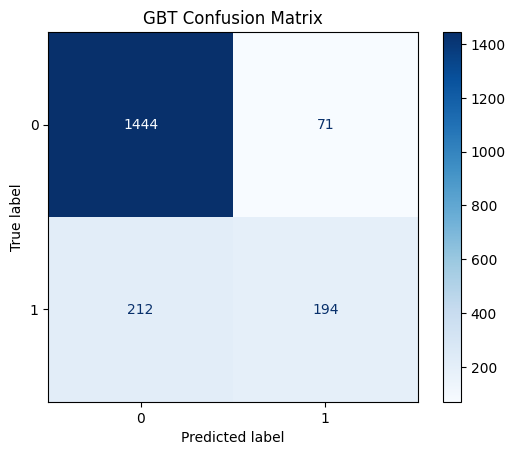

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

gbt_pd = gbt_predictions.select("prediction", "Exited").toPandas()

y_true = gbt_pd["Exited"]
y_pred = gbt_pd["prediction"]

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("GBT Confusion Matrix")
plt.show()


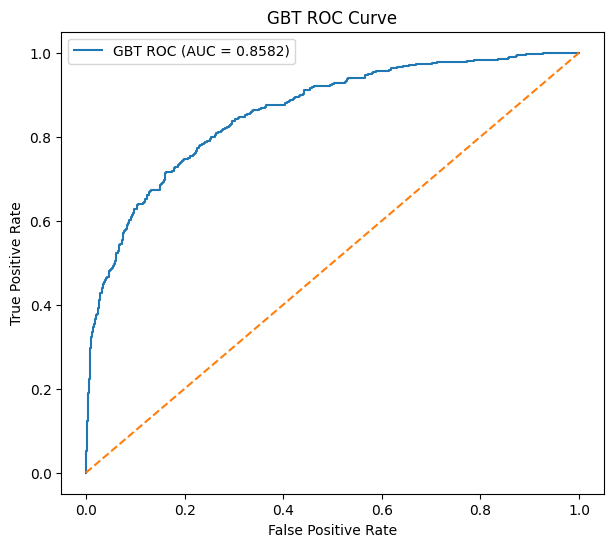

In [36]:
from sklearn.metrics import roc_curve, auc

gbt_pd = gbt_predictions.select("rawPrediction", "Exited").toPandas()
gbt_pd["score"] = gbt_pd["rawPrediction"].apply(lambda x: float(x[1]))

y_true = gbt_pd["Exited"]
y_scores = gbt_pd["score"]

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f'GBT ROC (AUC = {roc_auc:.4f})')
plt.plot([0,1],[0,1],'--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("GBT ROC Curve")
plt.legend()
plt.show()


In [37]:
rf_stage_model = rf_model.stages[-1]
importances = rf_stage_model.featureImportances

feature_importance = list(zip(assembler_inputs, importances.toArray()))
feature_importance_sorted = sorted(feature_importance, key=lambda x: x[1], reverse=True)

print("Feature Importances:")
for name, score in feature_importance_sorted:
    print(f"{name}: {score}")


Feature Importances:
Age: 0.4158718991550231
NumOfProducts: 0.32544668171423224
IsActiveMember: 0.09262162815123923
Balance: 0.040041857535305134
EstimatedSalary: 0.014889636129951062
CreditScore: 0.01291984636774244
Tenure: 0.00878596742523905
Geography_ohe: 0.007628509206066067
Gender_ohe: 0.0029526004485394704
HasCrCard: 0.001295543020599183


## Conclusion

In this project, multiple machine learning models were trained using PySpark to predict bank customer churn.

Among all models, Gradient Boosted Trees (GBT) achieved the highest AUC score, making it the best-performing model.

The model can help banks identify customers who are likely to churn and take proactive steps to improve retention.
